# Predicting Stock Price Movement and Volatility using Multimodal & Multitask Deep Learning  

#### Multimodal: 
Using price data and stock data as two inputs in two separate LSTMs and then concatenating them to form the model
#### Multitask: 
Predicting Volatility (continuous measure) and Price Movement Direction (discrete: up or down) using a single model

#### Datasets used:
##### 1. News Data 
Crawled Historical News Headlines from Reddit WorldNews Channel. It has top 25 headlines for each date from August 2008 to July 2016, i.e 8 years.
##### 2. Stock Data
Dow Jones Industrial Average (DJIA) OHLCV (Open, High, Low, Close, Volume) tuple for each trading day from August 2008 to July 2016.

#### Import
Importing the required libraries as well as preprocessing code.

In [1]:
#Importing the required libraries as well as preprocessing code.
%matplotlib inline
from process_data import *
from sklearn import preprocessing
import numpy as np
import os
os.environ['KERAS_BACKEND']='tensorflow'
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import merge, Input, concatenate, average, add
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import heapq

Using TensorFlow backend.


In [2]:
from keras.layers import concatenate
from keras.layers.merge import Concatenate, Average 
#merge = concatenate([tensor1, tensor2], axis=3)

In [3]:
import _pickle as cPickle

#### Load Data
Loading the price & news data and splitting each into test & training set. The sentences are converted to lists vectors of 100 dimensions using Google Word2Vec. Variables used are:

X_train : Time series data

X_train_text : word2vec decoded text data

Y_train : Labels for voaltility

Y_train2 : Labels for classification (movement direction)

In [4]:
#divide data into trainning part and test part
train, test = load_text_csv()
data_chng_train, data_chng_test = load_ts_csv()
test=pd.DataFrame(data=data_chng_test)
test.to_csv('test.csv',encoding='utf-8')

C:\Users\Lenovo X240\Finance project stock price prediction\process_data.py:34: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  train = df.loc[(pd.to_datetime(df["Date"]) <= date_split),['Label','Combined']]
C:\Users\Lenovo X240\Finance project stock price prediction\process_data.py:35: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  test = df.loc[(pd.to_datetime(df["Date"]) > date_split),['Label','Combined']]
C:\Users\Lenovo X240\Finance project stock price prediction\process_data.py:48: FutureWarning: Com

(1611, 5)
(378, 5)


In [5]:
#dump data into cPickle file
train_text = cPickle.load(open('train_text.p', 'rb'))[1:]
test_text = cPickle.load(open('test_text.p', 'rb'))[1:]

In [6]:
#use vector support machine to turn text data into vector
train_text_vectors, test_text_vectors, model = transform_text_into_vectors(train_text, test_text, 100)
#the dimension of each vector is 100
f = open("test2.txt", 'w+')
print(train_text_vectors, file=f)


In [7]:
train_text_vectors[0]

array([-0.6593814 , -0.0560312 , -0.18947667, -0.1778777 ,  0.19271293,
       -0.13249396, -0.1160062 , -0.09110744,  0.29757598, -0.02911181,
       -0.20013045, -0.3002018 , -0.06915292,  0.06157104, -0.18059644,
       -0.40010566, -0.40304878,  0.37613007,  0.2810813 , -0.12090328,
        0.07931337,  0.14065279, -0.2309055 , -0.44517192,  0.27331364,
        0.19429228,  0.04726438,  0.06684861,  0.38339198,  0.15422839,
       -0.25083557, -0.5001554 , -0.17155677,  0.52165526, -0.00713923,
        0.31680712,  0.5688122 , -0.26739404,  0.10021865, -0.32102725,
        0.55799234, -0.36245453, -0.53553975, -0.03642122,  0.34727284,
       -0.41763833,  0.3902075 ,  0.316021  ,  0.00985824, -0.00119006,
        0.17464621,  0.58483064,  0.23962602, -0.02677333,  0.05655961,
       -0.14482951,  0.20425811, -0.20477921, -0.04865098,  0.3044222 ,
       -0.36107007, -0.09508139,  0.03483608,  0.43174917, -0.7093214 ,
        0.25948274,  0.07957477, -0.19884162,  0.43703866,  0.15

In [8]:
#X_train, X_train_text, Y_train, Y_train2 = split_into_XY(data_chng_train, train_text_vectors, 1, 30, 1)
#X_test, X_test_text, Y_test, Y_test2 = split_into_XY(data_chng_test, test_text_vectors, 1, 30, 1)

In [9]:
#split data for train into windows
step=1
window=5
forecast=3
X_train, X_train_text, Y_train, Y_train2= [], [], [], []
for i in range(0, len(data_chng_train)-window-forecast, step): 
    try:
        x_i = data_chng_train[i:i+window]
        y_i = np.std(np.array(data_chng_train[i+window-forecast:i+window+forecast])[:,3])#volatility of stock price in each window close

        text_average = train_text_vectors[i:i+window]
        last_close = x_i[-1]#last

        y_i2 = None
        if np.mean(np.array(data_chng_train[i+window-forecast:i+window+forecast])[:,3]) > 0.:
            y_i2 = 1.
        else:
            y_i2 = 0.

    except Exception as e:
        print ('KEK')
        print (e)
    #break
    x_i=x_i.tolist()
    X_train.append(x_i)#x_i is the data in each window
    X_train_text.append(text_average)#step_number*window*（100）text_average is the text data in the targeted days(days in window) 
    Y_train.append(y_i)#step number*window*1 the changing rate vector
    Y_train2.append(y_i2)#step number*1 trend for each window(0 or 1)
#print(y_i)
#print(X_train)
#print(X_train_text)
#print(Y_train2)
#i
X_train, X_train_text, Y_train, Y_train2 = np.array(X_train), np.array(X_train_text), np.array(Y_train), np.array(Y_train2)

In [10]:
#split data for test into windows
step=1
window=5
forecast=3
X_test, X_test_text, Y_test, Y_test2= [], [], [], []
for i in range(0, len(data_chng_test)-window-forecast, step): 
    try:
        x_i = data_chng_test[i:i+window]
        s=0
        y_i = np.std(np.array(data_chng_test[i+window-forecast:i+window+forecast])[:,3])#volatility of stock price in each window close

        text_average = train_text_vectors[i:i+window]
        last_close = x_i[-1]#last

        y_i2 = None
        if np.mean(np.array(data_chng_test[i+window-forecast:i+window+forecast])[:,3]) > 0.:#if stock price increase on the day after window then 1
            y_i2 = 1.
        else:
            y_i2 = 0.

    except Exception as e:
        print ('KEK')
        print (e)
    #break
    x_i=x_i.tolist()
    X_test.append(x_i)
    X_test_text.append(text_average)
    Y_test.append(y_i)
    Y_test2.append(y_i2)
#print(y_i)
#print(X_test)
#print(X_test_text)
#print(Y_test2)
print(i)
X_test, X_test_text, Y_test, Y_test2 = np.array(X_test), np.array(X_test_text), np.array(Y_test), np.array(Y_test2)

369


In [11]:
np.std(data_chng_test[i:i+window+forecast][3])
i+window+forecast
i
a=np.array(data_chng_test[i:i+window+forecast])
a[:,3]
#np.matrix(data_chng_test[i:i+window+forecast])[3]
#print(data_chng_test[i])
#print(data_chng_test[i][3])
#print(data_chng_test[i+window+forecast][3])

array([ 0.00271206, -0.00165156,  0.01336408, -0.0359198 , -0.0180965 ,
        0.01777017,  0.01703267,  0.01356504])

In [12]:
print(X_train.shape)
print(X_train_text.shape)
print(Y_train.shape)
print(Y_train2.shape)
print(X_test.shape)
print(X_test_text.shape)
print(Y_test.shape)
print(Y_test.shape)
print(len(data_chng_test))

(1603, 5, 5)
(1603, 5, 100)
(1603,)
(1603,)
(370, 5, 5)
(370, 5, 100)
(370,)
(370,)
378


In [13]:

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],5))
 

#### Model Design
The model is made by concatenating two LSTMs, one (lstm1) takes OHLCV tuple as input and the other (lstm2) takes vector representation of news data. The two outputs of the model are volatility (standard deviation - x1) and price movement direction (up or down - x2)

In [14]:
#build LSTM model,input price and text data and use regression to predict the volatility and the trend.
main_input = Input(shape=(5, 5), name='ts_input')
text_input = Input(shape=(5, 100), name='text_input')
lstm1 = LSTM( units=4, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(main_input)
lstm1 = LSTM(5, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm1)
lstm1 = Flatten()(lstm1)
lstm2 = LSTM(2, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(text_input)
lstm2 = LSTM(3, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm2)
lstm2 = Flatten()(lstm2)


lstms = concatenate([lstm1, lstm2])


x1 = Dense(64)(lstms)
#the dimension of output is 64
x1 = LeakyReLU()(x1)
x1 = Dense(1, activation = 'linear', name='regression')(x1)

x2 = Dense(64)(lstms)
x2 = LeakyReLU()(x2)
x2 = Dropout(0.9)(x2)
x2 = Dense(1, activation = 'sigmoid', name = 'class')(x2)

final_model = Model(inputs=[main_input, text_input], 
              outputs=[x1, x2])

2019-04-09 23:20:07,638: WARNING: From C:\Users\Lenovo X240\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2019-04-09 23:20:07,716: WARNING: From C:\Users\Lenovo X240\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1150: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
2019-04-09 23:20:07,743: WARNING: From C:\Users\Lenovo X240\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2837: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate

#### Training the Model
Training parameter like loss, optimizer & learning rate are set as below.. Volatility error is measured using MSE & price movement direction by Binary Crossentropy.

In [15]:
#training the model
opt = Nadam(lr=0.002, clipnorm = 0.5)
#optimize the model,lr is the learning rate, clipnorm is to avoid gradient explosion and gradient disappear
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model.hdf5", verbose=1, save_best_only=True)
final_model.compile(optimizer=opt, loss={'regression': 'mse', 'class': 'binary_crossentropy'}, loss_weights=[1., 0.2])
#binary_crossentropy is always used to calculate the loss of Dichotomous(二分法)

The training is performed for 100 epochs over the dataset with a batchsize of 220.

In [16]:
history = final_model.fit([X_train, X_train_text], [Y_train, Y_train2],
		nb_epoch = 200, 
		batch_size = 50, #the data processed in one iteration
		verbose=1,                        
		validation_data=([X_test, X_test_text], [Y_test, Y_test2]), 
		callbacks=[reduce_lr, checkpointer], shuffle=True)

C:\Users\Lenovo X240\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
2019-04-09 23:20:09,932: WARNING: From C:\Users\Lenovo X240\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1603 samples, validate on 370 samples
Epoch 1/200
1603/1603 [==============================] - 6s - loss: 0.1620 - regression_loss: 0.0099 - class_loss: 0.7605 - val_loss: 0.1431 - val_regression_loss: 0.0017 - val_class_loss: 0.7071
Epoch 2/200
1603/1603 [==============================] - 0s - loss: 0.1444 - regression_loss: 0.0052 - class_loss: 0.6957 - val_loss: 0.1373 - val_regression_loss: 1.7709e-04 - val_class_loss: 0.6858
Epoch 3/200
1603/1603 [==============================] - 0s - loss: 0.1390 - regression_loss: 0.0023 - class_loss: 0.6834 - val_loss: 0.1370 - val_regression_loss: 5.9823e-05 - val_class_loss: 0.6848
Epoch 4/200
1603/1603 [==============================] - 0s - loss: 0.1370 - regression_loss: 0.0026 - class_loss: 0.6719 - val_loss: 0.1398 - val_regression_loss: 0.0018 - val_class_loss: 0.6902
Epoch 5/200
1603/1603 [==============================] - 0s - loss: 0.1374 - regression_loss: 0.0014 - class_loss: 0.6804 - val_loss: 0.1373 - val_regression_los

1603/1603 [==============================] - 0s - loss: 0.1355 - regression_loss: 1.5373e-04 - class_loss: 0.6769 - val_loss: 0.1376 - val_regression_loss: 1.0552e-04 - val_class_loss: 0.6875
Epoch 24/200
1603/1603 [==============================] - 0s - loss: 0.1349 - regression_loss: 2.6992e-04 - class_loss: 0.6731 - val_loss: 0.1372 - val_regression_loss: 1.8168e-05 - val_class_loss: 0.6860
Epoch 25/200
1603/1603 [==============================] - 0s - loss: 0.1352 - regression_loss: 1.3646e-04 - class_loss: 0.6751 - val_loss: 0.1372 - val_regression_loss: 3.8383e-05 - val_class_loss: 0.6859
Epoch 26/200
1603/1603 [==============================] - 0s - loss: 0.1347 - regression_loss: 1.3441e-04 - class_loss: 0.6727 - val_loss: 0.1374 - val_regression_loss: 7.0776e-05 - val_class_loss: 0.6865
Epoch 27/200
1603/1603 [==============================] - 0s - loss: 0.1340 - regression_loss: 1.4466e-04 - class_loss: 0.6692 - val_loss: 0.1379 - val_regression_loss: 3.4589e-04 - val_class_l

1603/1603 [==============================] - 0s - loss: 0.1348 - regression_loss: 1.0358e-04 - class_loss: 0.6732 - val_loss: 0.1380 - val_regression_loss: 4.8368e-04 - val_class_loss: 0.6878
Epoch 47/200
1603/1603 [==============================] - 0s - loss: 0.1349 - regression_loss: 1.5094e-04 - class_loss: 0.6739 - val_loss: 0.1375 - val_regression_loss: 8.8362e-05 - val_class_loss: 0.6869
Epoch 48/200
1603/1603 [==============================] - 0s - loss: 0.1346 - regression_loss: 1.2683e-04 - class_loss: 0.6723 - val_loss: 0.1376 - val_regression_loss: 2.4585e-05 - val_class_loss: 0.6880
Epoch 49/200
1603/1603 [==============================] - 0s - loss: 0.1344 - regression_loss: 1.0650e-04 - class_loss: 0.6716 - val_loss: 0.1376 - val_regression_loss: 1.9400e-05 - val_class_loss: 0.6878
Epoch 50/200
1603/1603 [==============================] - 0s - loss: 0.1349 - regression_loss: 1.0897e-04 - class_loss: 0.6738 - val_loss: 0.1377 - val_regression_loss: 3.3069e-05 - val_class_l

1603/1603 [==============================] - 0s - loss: 0.1342 - regression_loss: 9.4467e-05 - class_loss: 0.6708 - val_loss: 0.1374 - val_regression_loss: 1.9584e-05 - val_class_loss: 0.6871
Epoch 69/200
1603/1603 [==============================] - 0s - loss: 0.1344 - regression_loss: 9.6364e-05 - class_loss: 0.6716 - val_loss: 0.1374 - val_regression_loss: 1.5637e-04 - val_class_loss: 0.6862
Epoch 70/200
1603/1603 [==============================] - 0s - loss: 0.1342 - regression_loss: 9.5653e-05 - class_loss: 0.6708 - val_loss: 0.1376 - val_regression_loss: 8.2172e-05 - val_class_loss: 0.6874
Epoch 71/200
1603/1603 [==============================] - 0s - loss: 0.1344 - regression_loss: 1.1521e-04 - class_loss: 0.6715 - val_loss: 0.1378 - val_regression_loss: 1.2531e-04 - val_class_loss: 0.6884
Epoch 72/200
1603/1603 [==============================] - 0s - loss: 0.1341 - regression_loss: 1.1761e-04 - class_loss: 0.6699 - val_loss: 0.1379 - val_regression_loss: 2.0208e-05 - val_class_l

1603/1603 [==============================] - 0s - loss: 0.1287 - regression_loss: 9.3759e-05 - class_loss: 0.6429 - val_loss: 0.1296 - val_regression_loss: 2.6561e-04 - val_class_loss: 0.6468
Epoch 91/200
1603/1603 [==============================] - 0s - loss: 0.1294 - regression_loss: 1.0927e-04 - class_loss: 0.6466 - val_loss: 0.1296 - val_regression_loss: 2.5215e-05 - val_class_loss: 0.6477
Epoch 92/200
1603/1603 [==============================] - 0s - loss: 0.1275 - regression_loss: 1.0398e-04 - class_loss: 0.6369 - val_loss: 0.1266 - val_regression_loss: 9.6287e-05 - val_class_loss: 0.6325
Epoch 93/200
1603/1603 [==============================] - 0s - loss: 0.1250 - regression_loss: 1.2118e-04 - class_loss: 0.6245 - val_loss: 0.1233 - val_regression_loss: 4.4864e-05 - val_class_loss: 0.6163
Epoch 94/200
1603/1603 [==============================] - 0s - loss: 0.1238 - regression_loss: 1.1917e-04 - class_loss: 0.6186 - val_loss: 0.1270 - val_regression_loss: 4.1869e-05 - val_class_l

1603/1603 [==============================] - 0s - loss: 0.1191 - regression_loss: 8.0350e-05 - class_loss: 0.5951 - val_loss: 0.1129 - val_regression_loss: 1.9911e-05 - val_class_loss: 0.5642
Epoch 112/200
1603/1603 [==============================] - 0s - loss: 0.1168 - regression_loss: 7.7994e-05 - class_loss: 0.5835 - val_loss: 0.1121 - val_regression_loss: 2.1715e-05 - val_class_loss: 0.5606
Epoch 113/200
1603/1603 [==============================] - 0s - loss: 0.1169 - regression_loss: 7.9810e-05 - class_loss: 0.5841 - val_loss: 0.1142 - val_regression_loss: 2.2806e-05 - val_class_loss: 0.5709
Epoch 114/200
1603/1603 [==============================] - 0s - loss: 0.1150 - regression_loss: 7.6986e-05 - class_loss: 0.5744 - val_loss: 0.1109 - val_regression_loss: 1.5256e-04 - val_class_loss: 0.5539
Epoch 115/200
1603/1603 [==============================] - 0s - loss: 0.1175 - regression_loss: 8.8433e-05 - class_loss: 0.5870 - val_loss: 0.1098 - val_regression_loss: 2.5022e-05 - val_cla

1603/1603 [==============================] - 0s - loss: 0.1158 - regression_loss: 6.7304e-05 - class_loss: 0.5787 - val_loss: 0.1105 - val_regression_loss: 1.2667e-04 - val_class_loss: 0.5519
Epoch 134/200
1603/1603 [==============================] - 0s - loss: 0.1163 - regression_loss: 1.1103e-04 - class_loss: 0.5810 - val_loss: 0.1096 - val_regression_loss: 2.4036e-05 - val_class_loss: 0.5479
Epoch 135/200
1603/1603 [==============================] - 0s - loss: 0.1122 - regression_loss: 7.0261e-05 - class_loss: 0.5609 - val_loss: 0.1090 - val_regression_loss: 2.5321e-05 - val_class_loss: 0.5446
Epoch 136/200
1603/1603 [==============================] - 0s - loss: 0.1130 - regression_loss: 7.5621e-05 - class_loss: 0.5645 - val_loss: 0.1086 - val_regression_loss: 4.2884e-05 - val_class_loss: 0.5426
Epoch 137/200
1603/1603 [==============================] - 0s - loss: 0.1123 - regression_loss: 7.1361e-05 - class_loss: 0.5611 - val_loss: 0.1080 - val_regression_loss: 2.1198e-05 - val_cla

1603/1603 [==============================] - 0s - loss: 0.1133 - regression_loss: 6.6613e-05 - class_loss: 0.5660 - val_loss: 0.1092 - val_regression_loss: 1.8575e-04 - val_class_loss: 0.5448
Epoch 156/200
1603/1603 [==============================] - 0s - loss: 0.1130 - regression_loss: 6.4544e-05 - class_loss: 0.5648 - val_loss: 0.1075 - val_regression_loss: 1.2722e-05 - val_class_loss: 0.5376
Epoch 157/200
1603/1603 [==============================] - 0s - loss: 0.1159 - regression_loss: 5.5974e-05 - class_loss: 0.5793 - val_loss: 0.1083 - val_regression_loss: 4.8694e-05 - val_class_loss: 0.5412
Epoch 158/200
1603/1603 [==============================] - 0s - loss: 0.1126 - regression_loss: 5.6306e-05 - class_loss: 0.5627 - val_loss: 0.1085 - val_regression_loss: 1.2073e-05 - val_class_loss: 0.5427
Epoch 159/200
1603/1603 [==============================] - 0s - loss: 0.1121 - regression_loss: 5.2695e-05 - class_loss: 0.5602 - val_loss: 0.1082 - val_regression_loss: 1.7646e-05 - val_cla

1603/1603 [==============================] - 0s - loss: 0.1120 - regression_loss: 4.3315e-05 - class_loss: 0.5596 - val_loss: 0.1066 - val_regression_loss: 1.6095e-05 - val_class_loss: 0.5328
Epoch 178/200
1603/1603 [==============================] - 0s - loss: 0.1125 - regression_loss: 4.8097e-05 - class_loss: 0.5623 - val_loss: 0.1082 - val_regression_loss: 9.5589e-05 - val_class_loss: 0.5404
Epoch 179/200
1603/1603 [==============================] - 0s - loss: 0.1130 - regression_loss: 8.2661e-05 - class_loss: 0.5644 - val_loss: 0.1092 - val_regression_loss: 1.2002e-05 - val_class_loss: 0.5462
Epoch 180/200
1603/1603 [==============================] - 0s - loss: 0.1126 - regression_loss: 7.0902e-05 - class_loss: 0.5628 - val_loss: 0.1069 - val_regression_loss: 8.4702e-05 - val_class_loss: 0.5339
Epoch 181/200
1603/1603 [==============================] - 0s - loss: 0.1114 - regression_loss: 6.3828e-05 - class_loss: 0.5569 - val_loss: 0.1062 - val_regression_loss: 4.4962e-05 - val_cla

1603/1603 [==============================] - 0s - loss: 0.1117 - regression_loss: 7.8556e-05 - class_loss: 0.5580 - val_loss: 0.1065 - val_regression_loss: 1.0778e-05 - val_class_loss: 0.5324
Epoch 200/200
1603/1603 [==============================] - 0s - loss: 0.1113 - regression_loss: 5.4924e-05 - class_loss: 0.5561 - val_loss: 0.1073 - val_regression_loss: 6.6134e-05 - val_class_loss: 0.5364


#### Evaluation
The below graph shows how the overall training & test losses decreased during training. 

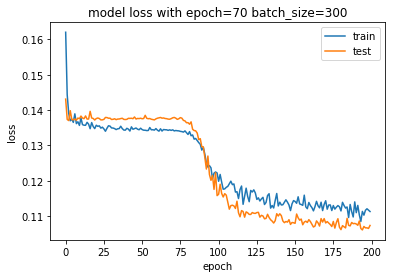

In [17]:
#shows how the overall training & test losses decreased during training
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with epoch=70 batch_size=300')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predictions of volatility are shown in blue while the actual volatility is in black. The model is very effective in capturing drastic changes in volatility. Note that these values are normalized (between 0 & 1).

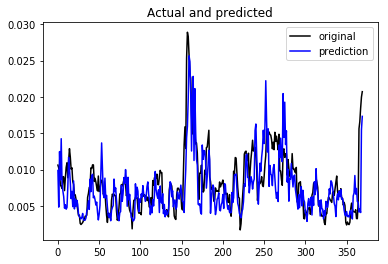

In [21]:
#test the accuraccy of the model
final_model.load_weights("model.hdf5")
pred = final_model.predict([X_test, X_test_text])[0]

predicted = pred
original = Y_test

pred2 = final_model.predict([X_test, X_test_text])[1]

predicted2 = pred2
original2 = Y_test2


plt.title('Actual and predicted')
plt.plot(original, color='black', label = 'Original data')
plt.plot(pred, color='blue', label = 'Predicted data')
plt.legend(['original', 'prediction'],loc='best')
plt.show()


370
370
correct catch of the high volatility: 0.7297297297297297
[ True  True False False False False False  True  True  True  True  True
 False False False False False  True  True  True  True False  True  True
  True  True  True  True False  True  True  True  True False False False
 False False False False False False False False  True  True  True  True
  True  True  True False False False False  True  True False False  True
  True  True  True  True  True False  True  True False False False  True
  True  True  True False False False False  True  True False False  True
  True  True False  True  True  True  True  True False  True False False
 False False False False  True False False False False  True  True  True
 False False  True  True  True  True  True False False False False False
 False  True  True False False False  True  True  True  True  True  True
  True False False False False False False  True  True  True False False
 False False False False  True False False  True  True  Tru

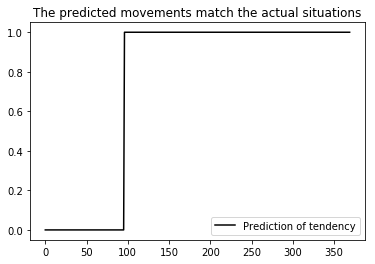

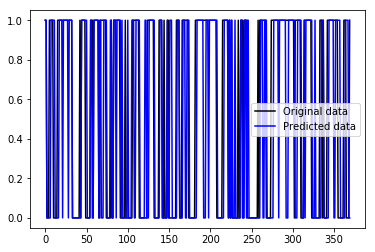

In [69]:
#a = np.array(np.array(pred) >= np.percentile(np.array(Y_test),70))
#b=np.array(Y_test >= np.percentile(Y_test,70))
a = np.array(np.array(pred) >=np.median(pred))
b=np.array(Y_test >= np.median(Y_test))
print(len(a))
print(len(b))
a=np.reshape(a,len(a),1)
b=np.reshape(b,len(a),1)
c=np.sum(a==b)/len(a==b)
print("correct catch of the high volatility:",c)


d= np.array(np.array(pred2) >= np.percentile(np.array(pred2),50))
d=np.reshape(d,len(a),1)
e=np.reshape(Y_test2,len(a),1)
pred_up=(d==True)
print(pred_up)
pred_up[pred_up==False]="down"
pred_down=(d==False)
pred_down[pred_down==False]=2
or_up=(Y_test2==True)
or_down=(Y_test2==False)
print("predict up=origin up",np.sum(pred_up==or_up))
print("predict down=origin down",np.sum(pred_down==or_down))
print("correct catch of trend:",np.sum(d==e)/len(d==e))
print(np.sum(d))
print(np.sum(d==e))
print(d==e)
plt.title('The predicted movements match the actual situations')
plt.plot(np.sort(e==d), color='black', label = 'Prediction of tendency')
plt.legend(loc='best')
plt.show()

plt.plot(e, color='black', label = 'Original data')
plt.plot(d, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.show()


In [43]:
#output 
pred_0=pd.DataFrame(pred)
pred_0.to_csv('pred_volatility.csv',encoding='utf-8')
Y_test_0=pd.DataFrame(Y_test)
Y_test_0.to_csv('real_volatility.csv',encoding='utf-8')
pred2_1=pd.DataFrame(pred2)
pred2_1.to_csv('pred_trend.csv',encoding='utf-8')
Y_test2_1=pd.DataFrame(Y_test2)
Y_test2_1.to_csv('real_trend.csv',encoding='utf-8')

In [28]:
len(final_model.predict([X_test, X_test_text])[1])

370

In [29]:
#see the accuracy of model from difference
print (np.mean(np.square(predicted - original)))
print (np.mean(np.abs(predicted - original)))
print (np.mean(np.abs((original - predicted) / original)))

0.00014400830899244529
0.011449076125334296
2.0614862783508694


In [30]:
cm=[[107,65],[ 49,126]]
cm=np.array(cm)
cm.shape
#print(final_model.predict([X_test, X_test_text])[0])


(2, 2)

# Implementation of Greedy Investment Strategy  

In [119]:
#it can be used to plot the confusion matrix to show the accuracy of prediction of trend
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm

In [372]:
#cnf_matrix = plot_confusion_matrix(cm, [0, 1])
#cnf_matrix

In [373]:
#read data, calculate the total number of trading days and total stock number(读数据，计算16年交易天数和总上市股票数)
filename = 'AMEX2016.csv' 
all_data = pd.read_csv(filename)
stock_code_unique=np.unique(all_data["X.ticker."])
date_unique=np.unique(all_data["X.date."])
date_unique_f=pd.DataFrame(date_unique.tolist(),columns=['Date'])
print(stock_code_unique)
len(stock_code_unique)
len(date_unique)
#date_unique_f

['AADR' 'AAMC' 'AAU' ... 'ZROZ' 'ZSL' 'ZVV']


261

In [270]:
##make return table(制作按stock code 分类的股价表和日回报率表)
rerange_table=[]
return_table=[]
for unit in stock_code_unique:
    target=[unit,all_data.loc[all_data["X.ticker."] == unit,['X.date.','X.close.']]]
    return_u=pd.DataFrame(data2change(all_data.loc[all_data["X.ticker."] == unit,'X.close.']))  
    date=pd.DataFrame(np.array(all_data.loc[all_data["X.ticker."] == unit,['X.date.']]),columns=['Date'])
    target_return=pd.DataFrame(data2change(all_data.loc[all_data["X.ticker."] == unit,'X.close.']),columns=['Return'])
    target_return=[unit,pd.concat([date,target_return],axis=1)]
    #target_return=[unit,pd.merge(date_unique_f,pd.concat([date,target_return],axis=1),how='outer',left_index=False, right_index=False)]
    rerange_table.append(target)
    return_table.append(target_return)


In [271]:
#return_table[0][1]
#a=stock_code_unique.tolist()
#a.index('EMX')
#return_table[a.index('EMX')][1]
#rerange_table[0][1]

,Date,Return
0,2016-12-27,0.000000
1,2016-12-28,0.011111
2,2016-12-29,0.153846
3,2016-12-30,-0.009524


In [11]:
##generate average return rate and standard deviation form in rolling windows
stock_no=len(stock_code_unique)

step=1
window=30
ave=[]
for j in range(0,len(stock_code_unique)): 
    ave_j=[]
    for i in range(0, len(date_unique)-window, step): 
        try:
            target_data = return_table[j][1].loc[i:i+window,:]
            ave_u=np.mean(target_data.loc[:,['Return']])
        except Exception as e:
            print ('KEK')
            print (e)
    #break
        ave_j.append(ave_u)
    ave_adj=list(map(float,ave_j))
        
    ave.append(ave_adj)

In [32]:
#print out the rolling window average return ration table
c=np.array(ave)
print(c.shape)
a=date_unique[-c.shape[1]-1:-1]
col=a.tolist()
a=stock_code_unique.tolist()
index=a
ave_df=pd.DataFrame(ave,columns=col,index=index)
ave_df
ave_df.to_csv('Average_return_window30.csv',encoding='utf-8')

(1790, 231)


In [374]:
price=[]
for j in range(0,len(stock_code_unique)): 
    arr=np.array(rerange_table[j][1].loc[:,'X.close.'])
    list=arr.tolist()
    price.append(list)
col=date_unique.tolist()
index=stock_code_unique.tolist()
#rerange_table2=pd.DataFrame(price,columns=col,index=index) 


In [181]:
return_rate=[]
for j in range(0,len(stock_code_unique)): 
    arr=np.array(return_table[j][1].loc[:,'Return'])
    list=arr.tolist()
    return_rate.append(list)
col=date_unique.tolist()
index=stock_code_unique.tolist()
rerange_return_table=pd.DataFrame(return_rate,columns=col,index=index)
#rerange_return_table

In [215]:
a=date_unique[-len(date_unique)+window-1:-1]
col=a.tolist()
len(col)
price_win=rerange_table2.loc[:,col]
a=stock_code_unique.tolist()
index=a
price_win_df=pd.DataFrame(price_win,columns=col,index=index)
price_win_df.to_csv('price_win_win30.csv',encoding='utf-8')
#price_win_df

In [182]:
a=date_unique[-len(date_unique)+window-1:-1]
col=a.tolist()
len(col)
return_win=rerange_return_table.loc[:,col]
a=stock_code_unique.tolist()
index=a
return_win_df=pd.DataFrame(return_win,columns=col,index=index)
return_win_df
return_win_df.to_csv('return_win_win30.csv',encoding='utf-8')

In [81]:
##generate rolling window average and standard deviation form（20min)
std=[]
for j in range(0,len(stock_code_unique)): 
    std_j=[]
    for i in range(0, len(date_unique)-window, step): 
        try:
            target_data = rerange_table2.iloc[j,range(i,i+window)]
            std_u=np.std(target_data)
        except Exception as e:
            print ('KEK')
            print (e)
    #break
        std_j.append(std_u)
        
    std.append(std_j)

In [88]:
c=np.array(std)
print(c.shape)
a=date_unique[-c.shape[1]-1:-1]
col=a.tolist()
a=stock_code_unique.tolist()
index=a
std_df=pd.DataFrame(std,columns=col,index=index)
std_df.to_csv('return_std_win30.csv',encoding='utf-8')

(1790, 231)


In [ ]:
#sum(return_win_df.iloc[0,:])
delet_index=[]
where_are_nan = np.isnan(ave_return_rate_m)
for i in range(0,len(stock_code_unique)):
    s=sum(return_win_df.iloc[i,:])
    if np.isnan(s)==1:
        delet_index.append(i)
delet_index

In [310]:
#turn dataframe to matrix
return_win_or=np.mat(return_win_df)
std_win_or=np.mat(std_df)
price_win_or=np.mat(price_win_df)
ave_return_rate_or=np.mat(ave_df)
#delete abnormal stocks with incompleted price data
stock_code_unique_new=np.delete(stock_code_unique, delet_index)
return_win_m=np.delete(return_win_or, delet_index, axis=0)
std_m=np.delete(std_win_or, delet_index, axis=0)
ave_return_rate_m=np.delete(ave_return_rate_or, delet_index, axis=0)
price_win_m=np.delete(price_win_or, delet_index, axis=0)

(1572, 231)

In [370]:
#implement the greedy strategy
return_per_wave=ave_return_rate_m/(std_m+0.01)
select_no=10
weight_or,stock_selected_index_or,stock_selected_or,stock_selected_return_per_wave_values_or,potfolio_pro=[],[],[],[],[]
for i in range(0,len(date_unique)-window-1):
    array=np.array(return_per_wave[:,i])
    stock_selected_index_win=heapq.nlargest(select_no, range(len(array)), array.take)
    stock_selected_win=stock_code_unique_new[stock_selected_index_win]
    stock_selected_return_per_wave_values_win=np.array(heapq.nlargest(select_no, array))
    weight_win=stock_selected_return_per_wave_values_win/sum(stock_selected_return_per_wave_value_win)
    weight_win_arr=np.array(weight_win)
    port=np.multiply(return_win_m[stock_selected_index_win,i+1],weight_win_arr)
    s=np.float(sum(port))

    weight_or.append(weight_win)
    stock_selected_index_or.append(stock_selected_index_win)
    stock_selected_or.append(stock_selected_win)
    stock_selected_return_per_wave_values_or.append(stock_selected_return_per_wave_values_win)
    potfolio_pro.append(s)


array([[0.13645188],
       [0.09413814],
       [0.05430997],
       [0.04794218],
       [0.04447732],
       [0.04057646],
       [0.03571788],
       [0.02909197],
       [0.02888135],
       [0.02744617]])

In [369]:
#reshape the array data to two dimensions for ouputing csv dataframe
shape=np.array(weight).shape

weight=np.array(weight).reshape([shape[0],shape[1]]).tolist()

stock_selected_index=np.array(stock_selected_index).reshape([shape[0],shape[1]]).tolist()

stock_selected=np.array(stock_selected).reshape([shape[0],shape[1]]).tolist()

stock_selected_return_per_wave_values=np.array(stock_selected_return_per_wave_values).reshape([shape[0],shape[1]]).tolist()

np.array(weight).shape

[0.13645187890998764,
 0.09413813526513767,
 0.054309966803136864,
 0.047942183329413704,
 0.04447732249144779,
 0.040576458458563655,
 0.0357178795587436,
 0.029091972976094192,
 0.028881348622263877,
 0.02744616549100838]

In [371]:
#output
a=date_unique[-len(date_unique)+window:-1]
index=a
weight_df=pd.DataFrame(weight,index=index)
weight_df
weight_df.to_csv('weight_win30.csv',encoding='utf-8')

stock_selected_index_df=pd.DataFrame(stock_selected_index,index=index)
stock_selected_index_df
stock_selected_index_df.to_csv('stock_selected_index_win30.csv',encoding='utf-8')

stock_selected_df=pd.DataFrame(stock_selected,index=index)
stock_selected_df
stock_selected_df.to_csv('stock_selected_win30.csv',encoding='utf-8')

stock_selected_return_per_wave_values_df=pd.DataFrame(stock_selected_return_per_wave_values,index=index)
stock_selected_return_per_wave_values_df
stock_selected_return_per_wave_values_df.to_csv('stock_selected_return_per_wave_value_win30.csv',encoding='utf-8')

potfolio_pro_df=pd.DataFrame(potfolio_pro,index=index)
potfolio_pro_df
potfolio_pro_df.to_csv('potfolio_profit_win30.csv',encoding='utf-8')